<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/rice-quality-classification/blob/master/klasifikasi_kualitas_beras_3varietas_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KLASIFIKASI KUALITAS BERAS 3 VARIETAS MobileNet**

In [1]:
!apt-get install subversion > /dev/null
!svn export https://github.com/Soedirman-Machine-Learning/rice-quality-classification/trunk/dataset_f > /dev/null


Insert Library

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import pandas as pd
import math, os, sys
import itertools
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage
from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical


import Dataset

In [3]:
!ls dataset_f/
!ls dataset_f/train/
!ls dataset_f/train/Ir64_medium/
!ls dataset_f/train/Ir64_tidak_layak/
!ls dataset_f/train/ir64_premium/
!ls dataset_f/train/pandan_wangi_medium/
!ls dataset_f/train/pandan_wangi_premium/
!ls dataset_f/train/pandan_wangi_tidak_layak/
!ls dataset_f/train/rojo_lele_medium/
!ls dataset_f/train/rojo_lele_premium/
!ls dataset_f/train/rojo_lele_tidak_layak/

test  train
Ir64_medium	  pandan_wangi_medium	    rojo_lele_medium
ir64_premium	  pandan_wangi_premium	    rojo_lele_premium
Ir64_tidak_layak  pandan_wangi_tidak_layak  rojo_lele_tidak_layak
ir64_medium_001.jpg  ir64_medium_028.jpg  ir64_medium_055.jpg
ir64_medium_002.jpg  ir64_medium_029.jpg  ir64_medium_056.jpg
ir64_medium_003.jpg  ir64_medium_030.jpg  ir64_medium_057.jpg
ir64_medium_004.jpg  ir64_medium_031.jpg  ir64_medium_058.jpg
ir64_medium_005.jpg  ir64_medium_032.jpg  ir64_medium_059.jpg
ir64_medium_006.jpg  ir64_medium_033.jpg  ir64_medium_060.jpg
ir64_medium_007.jpg  ir64_medium_034.jpg  ir64_medium_061.jpg
ir64_medium_008.jpg  ir64_medium_035.jpg  ir64_medium_062.jpg
ir64_medium_009.jpg  ir64_medium_036.jpg  ir64_medium_063.jpg
ir64_medium_010.jpg  ir64_medium_037.jpg  ir64_medium_064.jpg
ir64_medium_011.jpg  ir64_medium_038.jpg  ir64_medium_065.jpg
ir64_medium_012.jpg  ir64_medium_039.jpg  ir64_medium_066.jpg
ir64_medium_013.jpg  ir64_medium_040.jpg  ir64_medium_067.jpg
ir6

rojo_lele_premium


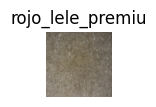

pandan_wangi_medium


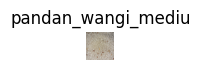

Ir64_tidak_layak


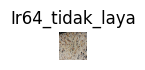

pandan_wangi_premium


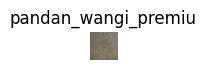

rojo_lele_medium


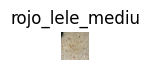

pandan_wangi_tidak_layak


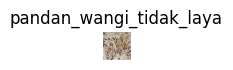

Ir64_medium


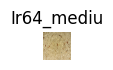

rojo_lele_tidak_layak


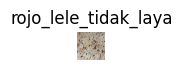

ir64_premium


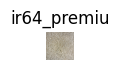

In [4]:
plt.figure(figsize=(15,10))

#visualize several images

parent_directory = "dataset_f/test/"

for i, folder in enumerate(os.listdir(parent_directory)):
    print(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    file = files[0] 
    file_path = os.path.join(folder_directory,file)
    
    image = imread(file_path)
    plt.subplot(1,15,i+1)
    plt.imshow(image)
    plt.axis("off")
    
    name = folder.split("___")[0][:-1]
    plt.title(name)
    plt.show()


Membuat dataset pelatihan dan pengujian

In [5]:
#dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 8
base_dir = os.path.join('dataset_f/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Ir64_medium', 'Ir64_tidak_layak', 'ir64_premium',
          'pandan_wangi_medium', 'pandan_wangi_premium', 'pandan_wangi_tidak_layak', 
          'rojo_lele_medium', 'rojo_lele_premium', 'rojo_lele_tidak_layak']

for i,label in enumerate(labels):
    folder = os.path.join("dataset_f/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_gen:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_gen:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 576 images belonging to 9 classes.
Found 144 images belonging to 9 classes.
Bentuk array dari dataset train (pelatihan) adalah: (8, 224, 224, 3) (8, 9)
Bentuk array dari dataset validation (validasi) adalah: (8, 224, 224, 3) (8, 9)
Bentuk array dari dataset test (pengujian) adalah: (180, 224, 224, 3) (180,)


Save Label

In [6]:
print (train_gen.class_indices)

labels_txt = '\n'.join(sorted(train_gen.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

!cat labels.txt

{'Ir64_medium': 0, 'Ir64_tidak_layak': 1, 'ir64_premium': 2, 'pandan_wangi_medium': 3, 'pandan_wangi_premium': 4, 'pandan_wangi_tidak_layak': 5, 'rojo_lele_medium': 6, 'rojo_lele_premium': 7, 'rojo_lele_tidak_layak': 8}
Ir64_medium
Ir64_tidak_layak
ir64_premium
pandan_wangi_medium
pandan_wangi_premium
pandan_wangi_tidak_layak
rojo_lele_medium
rojo_lele_premium
rojo_lele_tidak_layak

Membuat Model dari jaringan CNN

In [7]:
#base model
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False
base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [8]:
#mempersiapkan data masukan
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)


Membuat pemodelan

In [9]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(9, activation='softmax')
])
model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 9)                 297       
Total params: 3,524,105
Trainable params: 295,241
Non-trainable params: 3,228,864
_________________________________________________________________


In [10]:
#training
epoch=100
history = model.fit_generator(train_gen, 
                    epochs=epoch, 
                    validation_data=val_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
72/72 [==============================] - 7s 95ms/step - loss: 1.2000 - acc: 0.5642 - val_loss: 0.6615 - val_acc: 0.7569
Epoch 2/100
72/72 [==============================] - 6s 87ms/step - loss: 0.2373 - acc: 0.9358 - val_loss: 0.3183 - val_acc: 0.9028
Epoch 3/100
72/72 [==============================] - 6s 87ms/step - loss: 0.0892 - acc: 0.9809 - val_loss: 0.2108 - val_acc: 0.9236
Epoch 4/100
72/72 [==============================] - 6s 88ms/step - loss: 0.0420 - acc: 0.9931 - val_loss: 0.2535 - val_acc: 0.8958
Epoch 5/100
72/72 [==============================] - 6s 88ms/step - loss: 0.0303 - acc: 0.9931 - val_loss: 0.1895 - val_acc: 0.9097
Epoch 6/100
72/72 [==============================] - 6s 88ms/step - loss: 0.0181 - acc: 0.9983 - val_loss: 0.1985 - val_acc: 0.9444
Epoch 7/100
72/72 [==============================] - 6s 88ms/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.1508 - val_acc: 0.9375


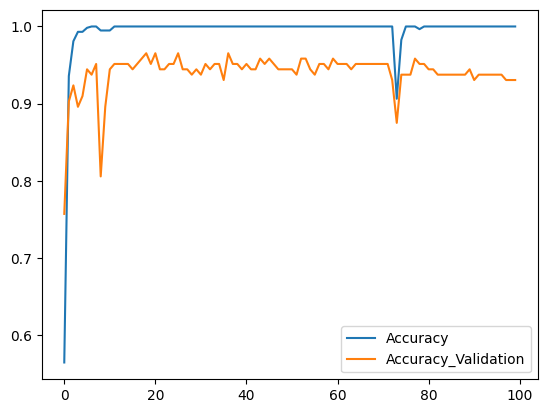

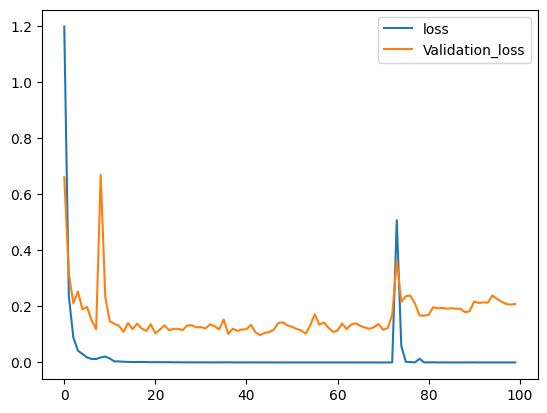

In [11]:
plt.plot(history.history["acc"],label="Accuracy")
plt.plot(history.history["val_acc"],label="Accuracy_Validation")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="Validation_loss")
plt.legend()
plt.show()

In [12]:
#Prediksi Label Validasi dengan Pelatihan
n = 0
input_image = image_batch[n][np.newaxis,...]
print("True Label: ", label_batch[n])

predictions = model.predict(input_image)
print("Predicted label",predictions[0])

True Label:  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted label [4.3640558e-34 3.9581940e-26 4.0636042e-20 7.3561729e-24 1.0000000e+00
 7.3903131e-33 6.7456932e-24 6.7426073e-16 7.2530857e-36]


In [13]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))


['loss', 'acc']
6/6 [==============================] - 0s 57ms/step - loss: 1.5057 - acc: 0.7722
[1.5057154893875122, 0.7722222208976746]


In [14]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#True Label
y_true = np.argmax(y_test2,axis=1)

#Predicted label
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print("True_label = ",y_true)
print("Predicted label = ",y_pred)

True_label =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Predicted label =  [0 3 0 0 3 0 0 3 0 0 3 3 0 0 3 3 0 3 0 0 1 8 1 5 1 5 8 1 1 1 1 1 5 1 1 8 8
 1 1 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 0 6 6 6 6 6 6 6 0 6 6 0 6 6 6 6 6 6 6 6 4 4 4 4 2 2 2 4
 4 2 4 4 4 4 4 2 2 4 4 2 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8]


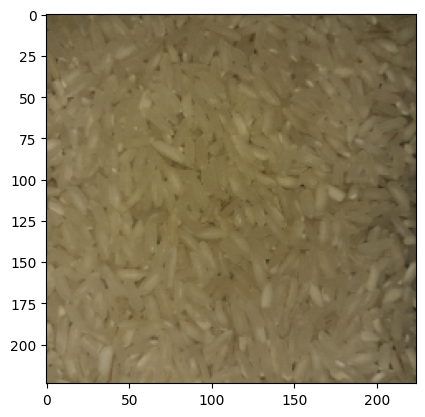

true_label: 7 : rojo_lele_premium
prediction: [9.93767134e-22 6.92692829e-15 1.74999319e-03 3.26802184e-14
 9.98181343e-01 4.57670397e-17 2.85366267e-13 6.86814310e-05
 1.20267465e-20]
predicted_label: 4 : pandan_wangi_premium
predicted_label


In [15]:
n = 147 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("true_label:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("prediction:",prediction)
predicted_label = np.argmax(prediction)
print("predicted_label:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("true_label")
else:
    print("predicted_label")

Normalized confusion matrix
[[0.6  0.   0.   0.4  0.   0.   0.   0.   0.  ]
 [0.   0.6  0.   0.   0.   0.15 0.   0.   0.25]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.05 0.   0.95 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.15 0.   0.   0.   0.   0.   0.85 0.   0.  ]
 [0.   0.   0.35 0.   0.65 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.05 0.   0.95]]


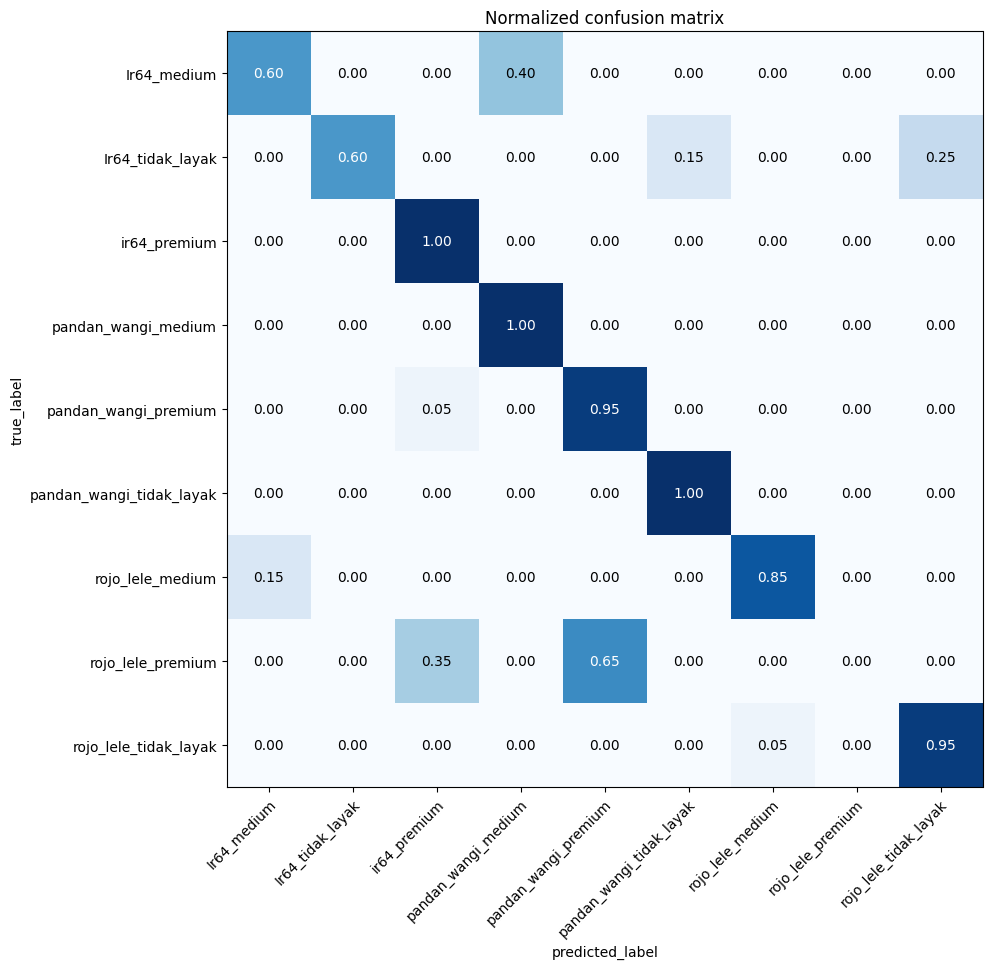

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='true_label',
           xlabel='predicted_label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')


Menyimpan dan Konversi ke ".tflite"

In [17]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_kualitas_Beras_3varietas_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
